In [ ]:
# Install libraries
!pip install -r requirements.txt

In [289]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import power_transform, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skew, kurtosis

In [266]:
# Read data
df = pd.read_csv('data/data.csv')

In [267]:
# Display dataframe head
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [268]:
# Shape of the dataset
df.shape

(4600, 18)

In [269]:
# General statistics on the dataset. No NAs observed.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [270]:
# Convert date to correct format
df['date'] = pd.to_datetime(df['date'])

In [271]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


Some things to consider

1. The house prices start from 0. This seems to be an error, or maybe a change in title deed.
2. 'view' is either 4 or 0. 
3. Condition is 1 to 5. Is it correlated to yr_renovated or time since renovation?

The above mentioned will be reviewed in detail.

<AxesSubplot:>

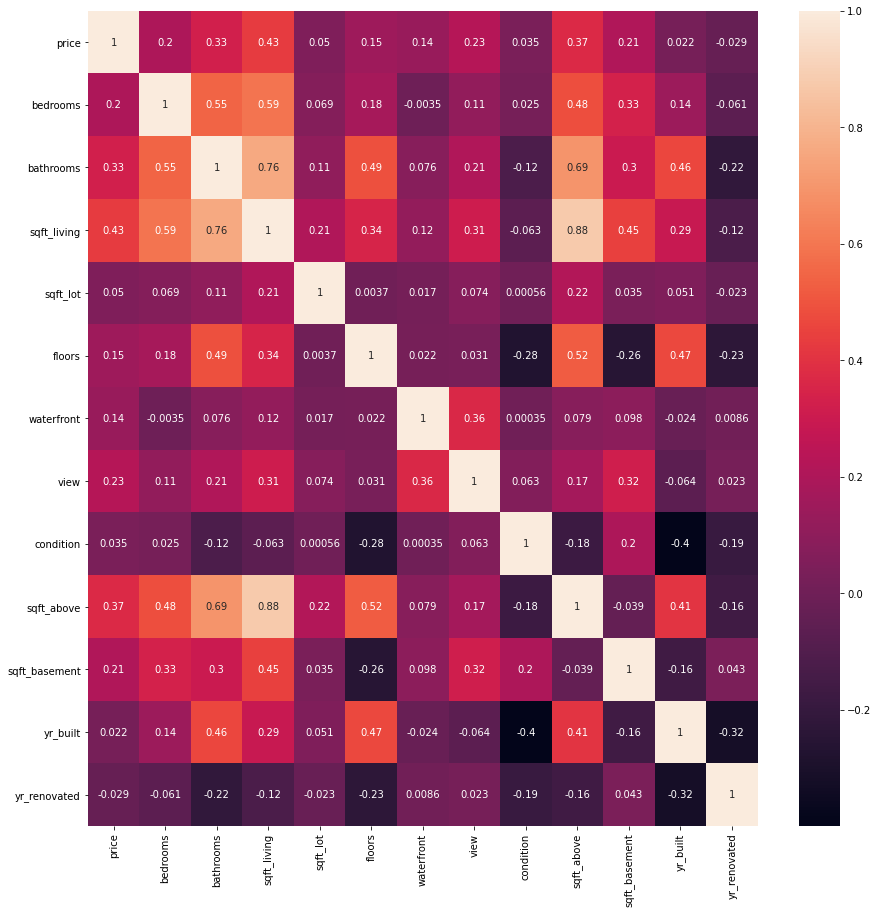

In [272]:
# In the correlation matrix below, we see sqft_living is correlated with sqft_above and bathrooms at 0.85 and 0.72 respectively.
# We may have to consider removing sqft_above altogether in model development.
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)

<AxesSubplot:xlabel='sqft_living', ylabel='bathrooms'>

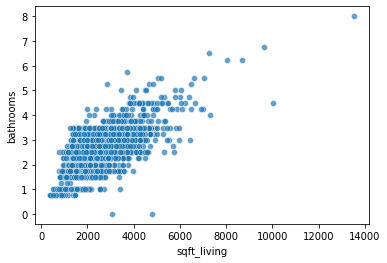

In [273]:
# High correlation between sqft_living and sqft_above
sns.scatterplot(data=df, x = 'sqft_living', y = 'bathrooms', alpha=0.7)

<AxesSubplot:xlabel='sqft_living', ylabel='sqft_above'>

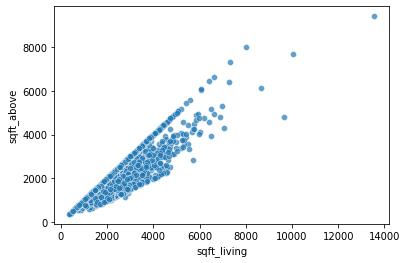

In [274]:
# High correlation between sqft_living and sqft_above
sns.scatterplot(data=df, x = 'sqft_living', y = 'sqft_above', alpha=0.7)

<AxesSubplot:title={'center':'Price Distribution - Less than 1mn'}>

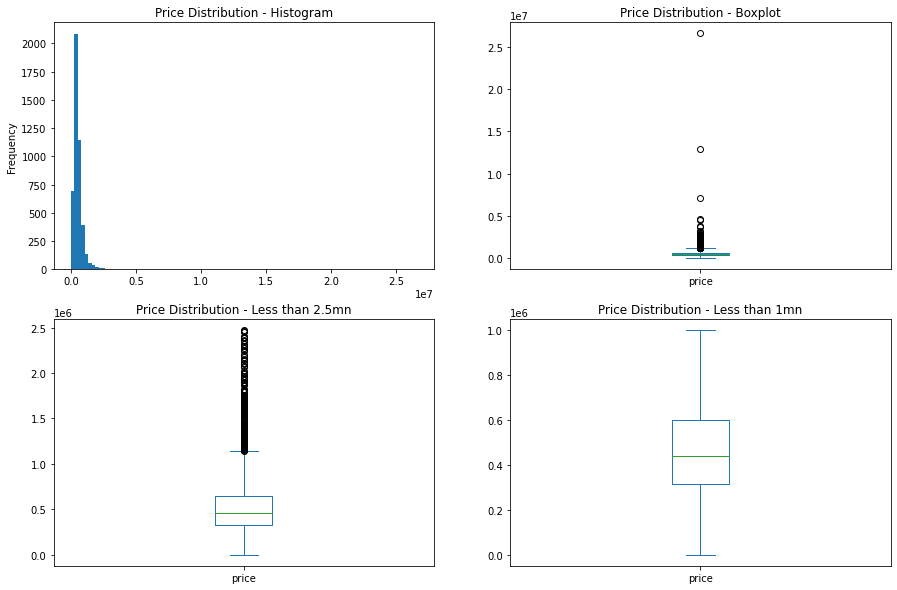

In [275]:
# We can see below that price is highly skewed with outliers. Let's review these in detail.
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df['price'].plot(kind='hist', bins=100, ax=ax[0,0], title='Price Distribution - Histogram')
df['price'].plot(kind='box', ax=ax[0,1], title='Price Distribution - Boxplot')
df.loc[df['price'] < 2500000, 'price'].plot(kind='box', ax=ax[1,0], title='Price Distribution - Less than 2.5mn')
df.loc[df['price'] < 1000000, 'price'].plot(kind='box', ax=ax[1,1], title='Price Distribution - Less than 1mn')

In [276]:
# There are 340 observations (~7%) that have price above 1mn. More time can be spent to review other features, but we are removing them for now.
df[df['price'] > 1000000].shape

(340, 18)

In [277]:
df = df[df['price'] <= 1000000]

<AxesSubplot:xlabel='price', ylabel='Count'>

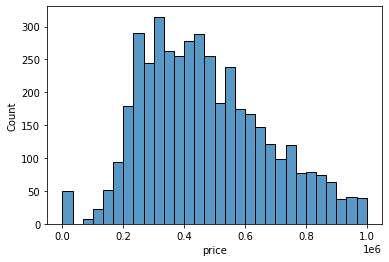

In [278]:
sns.histplot(data=df, x = 'price', bins=30)

In [279]:
# We can also see there are cases where price is 0. These values can be imputed using kNN or other factor. We can come back to this at a later stage. For now we will remove them.
df[df['price'] == 0].head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4354,2014-05-05,0.0,3.0,1.75,1490,10125,1.0,0,0,4,1490,0,1962,0,3911 S 328th St,Federal Way,WA 98001,USA
4356,2014-05-05,0.0,4.0,2.75,2600,5390,1.0,0,0,4,1300,1300,1960,2001,2120 31st Ave W,Seattle,WA 98199,USA
4357,2014-05-05,0.0,6.0,2.75,3200,9200,1.0,0,2,4,1600,1600,1953,1983,12271 Marine View Dr SW,Burien,WA 98146,USA
4358,2014-05-06,0.0,5.0,3.50,3480,36615,2.0,0,0,4,2490,990,1983,0,21809 SE 38th Pl,Issaquah,WA 98075,USA
4361,2014-05-07,0.0,5.0,1.50,1500,7112,1.0,0,0,5,760,740,1920,0,14901-14999 12th Ave SW,Burien,WA 98166,USA


In [280]:
# Remove cases where price is zero.
df = df[df['price'] != 0]

0.5470824223944938

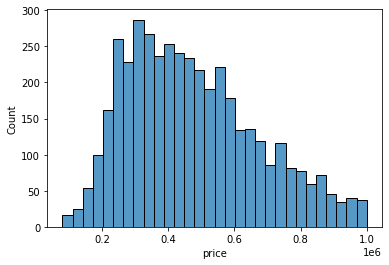

In [290]:
# There is a case where price is 7800. This also seems an anomaly, and will remove this for now too.
sns.histplot(data=df, x = 'price', bins=30)
skew(df['price'])

In [282]:
df[df['price'] == 7800]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
4351,2014-05-06,7800.0,2.0,1.0,780,16344,1.0,0,0,1,780,0,1942,0,4229 S 144th St,Tukwila,WA 98168,USA


In [283]:
df = df[df['price'] != 7800]

array([-0.02661138])

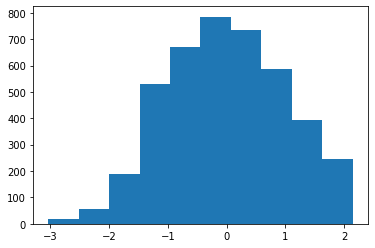

In [295]:
# Power transformation reduces the skewness in distribution.
pt = PowerTransformer(method='yeo-johnson')
test = np.array(df['price']).reshape(-1, 1)
pt.fit(test)
test_tr = pt.transform(test)
plt.hist(test_tr)
skew(test_tr)

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

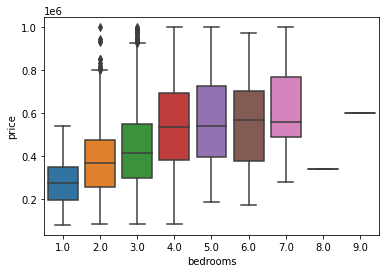

In [249]:
# We can see generally with no. of bedrooms the price increases.
sns.boxplot(data=df, x = 'bedrooms', y = 'price')

<AxesSubplot:xlabel='bedrooms', ylabel='sqft_living'>

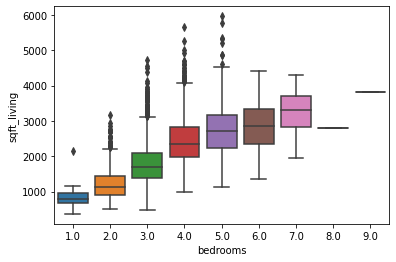

In [250]:
# This is mainly due to the size of the house
sns.boxplot(data=df, x = 'bedrooms', y = 'sqft_living')

0.46296431848845515

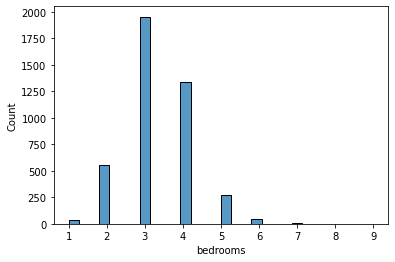

In [292]:
# Bedrooms is also skewed.
sns.histplot(data=df, x = 'bedrooms', bins=30)
skew(df['bedrooms'])

array([0.02298053])

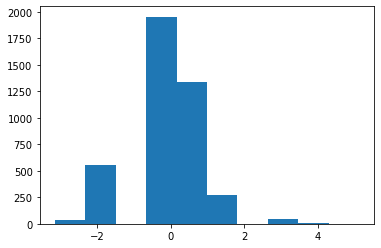

In [293]:
# Transformation can normalize the distribution
pt = PowerTransformer()
test = np.array(df['bedrooms']).reshape(-1, 1)
pt.fit(test)
test_tr = pt.transform(test)
plt.hist(test_tr)
skew(test_tr)

0.7894845389165234

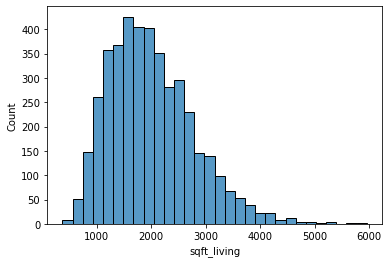

In [296]:
# Same is observed for sqft_living
sns.histplot(data=df, x = 'sqft_living', bins=30)
skew(df['sqft_living'])

array([-0.00807618])

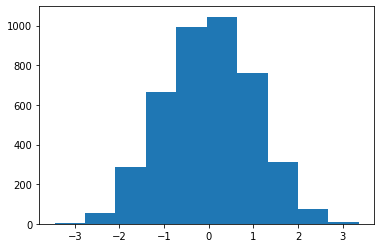

In [297]:
# Power transformation removes skewness
pt = PowerTransformer()
test = np.array(df['sqft_living']).reshape(-1, 1)
pt.fit(test)
test_tr = pt.transform(test)
plt.hist(test_tr)
skew(test_tr)

In [251]:
# There are two instances where we have 8 and 9 bedroom houses
df[df['bedrooms'] >= 8]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
241,2014-05-07,599999.0,9.0,4.50,3830,6988,2.5,0,0,3,2450,1380,1938,2003,8809 Densmore Ave N,Seattle,WA 98103,USA
3911,2014-07-03,340000.0,8.0,2.75,2790,6695,1.0,0,0,3,1470,1320,1977,2004,17512 Corliss Ave N,Shoreline,WA 98133,USA


In [252]:
# We can just remove the above data points or include in 6 bed and make a new variable. For now we'll delete them.
df = df[df['bedrooms'] < 8]

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

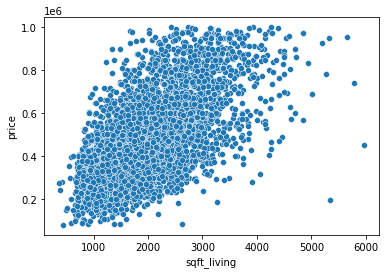

In [253]:
# We can see a strong relationship between sqft_living and price, also shown in the correlation matrix.
sns.scatterplot(data=df, x = 'sqft_living', y = 'price')

0    4193
1      15
Name: waterfront, dtype: int64


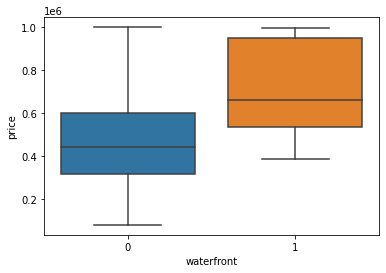

In [254]:
# Although we can observe a difference in prices by waterfront, we have very few observations for waterfront houses.
sns.boxplot(data=df, x = 'waterfront', y = 'price')
print(df['waterfront'].value_counts())

<AxesSubplot:xlabel='floors', ylabel='price'>

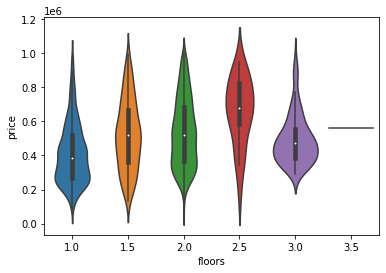

In [255]:
# We can see an increasing average with floors, but has high variation in prices.
sns.violinplot(data=df, x = 'floors', y = 'price')

In [256]:
# We'll remove one observation with 3.5 floors.
df = df[df['floors'] < 3.5]

0    3903
2     163
3      63
1      50
4      28
Name: view, dtype: int64


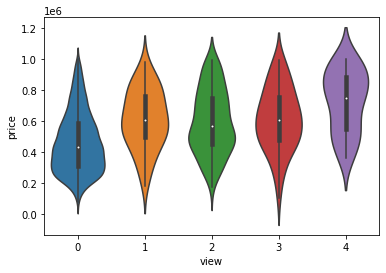

In [257]:
# Similar to floors, view also has an increasing average, however, there is a lot of variance observed.
sns.violinplot(data=df, x = 'view', y = 'price')
print(df['view'].value_counts())

<AxesSubplot:xlabel='renovated', ylabel='price'>

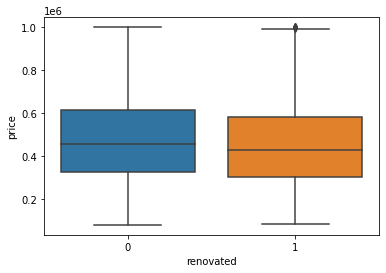

In [258]:
# Instead of using yr_built and yr_renovated, we can create 'years since construction' and 'renovated'
df['yrs_since_constructed'] = df['date'].dt.year - df['yr_built']

df['renovated'] = df['date'].dt.year - df['yr_renovated']
df['renovated'] = df['renovated'].apply(lambda x: 0 if x == 2014 else 1)

sns.boxplot(data=df, x = 'renovated', y = 'price')

In [259]:
# Since there is only USA as a country, we'll drop this column
print(df['country'].value_counts())
df.drop('country', axis=1, inplace=True)

USA    4207
Name: country, dtype: int64


<AxesSubplot:xlabel='statezip', ylabel='price'>

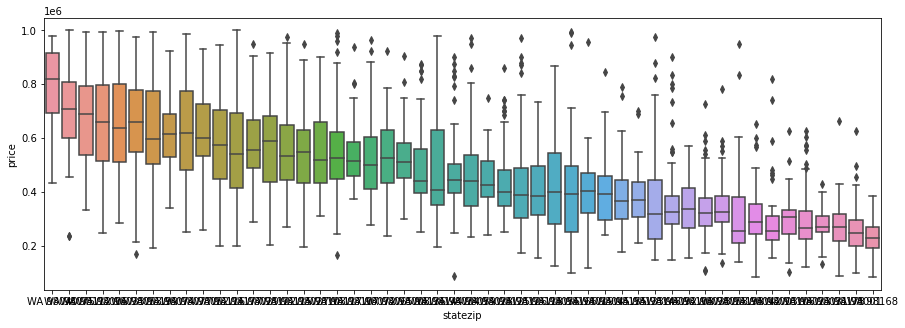

In [260]:
# Looking at 50 most frequent zip codes, we can see that the average varies significantly across zip codes, however there is a lot of overlapping variance.
top_50_zips = df['statezip'].value_counts()[:50]
top_50_zip_houses = df[df['statezip'].apply(lambda x: x in top_50_zips)]
sort_order = top_50_zip_houses.groupby('statezip')['price'].mean().sort_values(ascending=False).index
plt.figure(figsize=(15,5))
sns.boxplot(data=top_50_zip_houses, x = 'statezip', y = 'price', order=sort_order)

<AxesSubplot:xlabel='city', ylabel='price'>

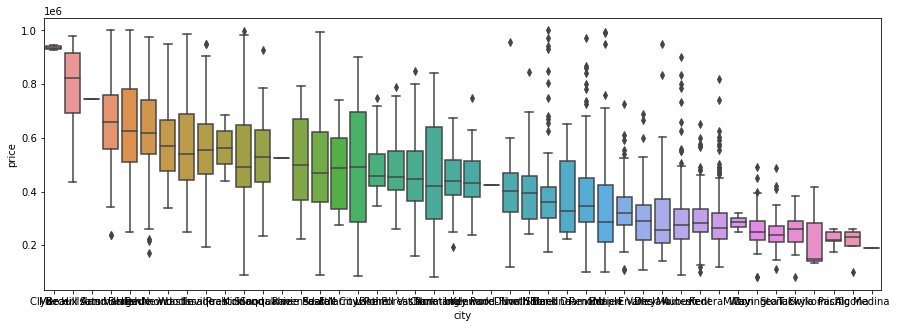

In [261]:
# A similar trend is observed by city as well.
top_50_cities = df['city'].value_counts()[:50]
top_50_city_houses = df[df['city'].apply(lambda x: x in top_50_cities)]
sort_order = top_50_city_houses.groupby('city')['price'].mean().sort_values(ascending=False).index
plt.figure(figsize=(15,5))
sns.boxplot(data=top_50_city_houses, x = 'city', y = 'price', order=sort_order)

In [262]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,yrs_since_constructed,renovated
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,59,1
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,48,0
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,51,0
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,38,1
5,2014-05-02,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,76,1


<AxesSubplot:xlabel='bedrooms', ylabel='price'>

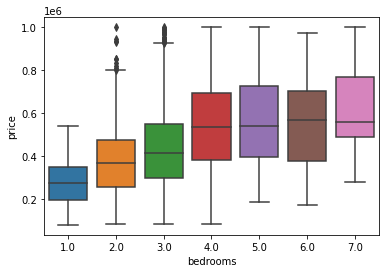

In [263]:
# Bathrooms have similar trend to bedrooms, but with high variance.
sns.boxplot(data=df, x = 'bedrooms', y = 'price')

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

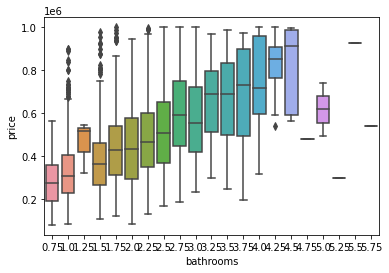

In [264]:
# Bathrooms have similar trend to bedrooms, but with high variance.
sns.boxplot(data=df, x = 'bathrooms', y = 'price')

In [152]:
# Define numerical and categorical variables
num_vars = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'sqft_basement', 'yr_built', 'yr_renovated']
#'sqft_above', 'waterfront', 
cat_vars = ['street', 'city', 'zip']
target = 'price'

In [298]:
# Split data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[num_vars], df[target])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [299]:
# Define model training function
def train_model(model, X_train, y_train, X_val, y_val, power_transform=False):
    # Train model
    rgr = model
    if power_transform == True:
        pt = PowerTransformer()
        X_train = pt.fit_transform(np.array(X_train))
        X_val = pt.transform(np.array(X_val))
    rgr.fit(X_train, y_train)
    train_preds = rgr.predict(X_train)
    val_preds = rgr.predict(X_val)
        
    rmse_train = round(np.sqrt(mean_squared_error(y_train, train_preds)), 2)
    corr_train = round(np.corrcoef(y_train, train_preds)[0][1], 2)
    rmse_valid = round(np.sqrt(mean_squared_error(y_val, val_preds)), 2)
    corr_valid = round(np.corrcoef(y_val, val_preds)[0][1], 2)
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(y_train, train_preds)
    ax[0].title.set_text('RMSE Train: {}\nCorr Train: {}'.format(rmse_train, corr_train))
    ax[1].scatter(y_val, val_preds)
    ax[1].title.set_text('RMSE Valid: {}\nCorr Valid: {}'.format(rmse_valid, corr_valid))
    plt.show()

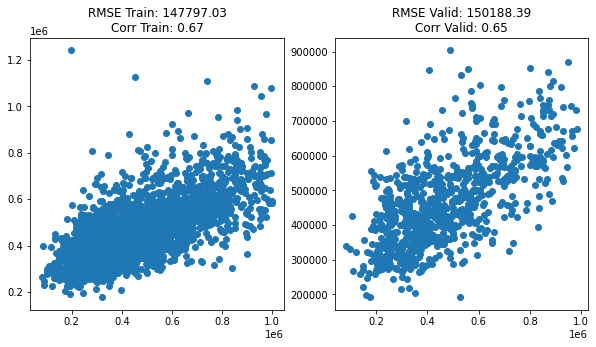

In [300]:
# Train linear regression model
train_model(LinearRegression(), X_train, y_train, X_val, y_val, power_transform=False)

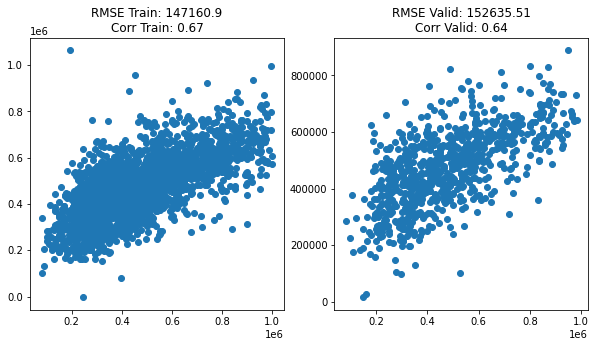

In [301]:
# Train linear regression with power transform
train_model(LinearRegression(), X_train, y_train, X_val, y_val, power_transform=True)

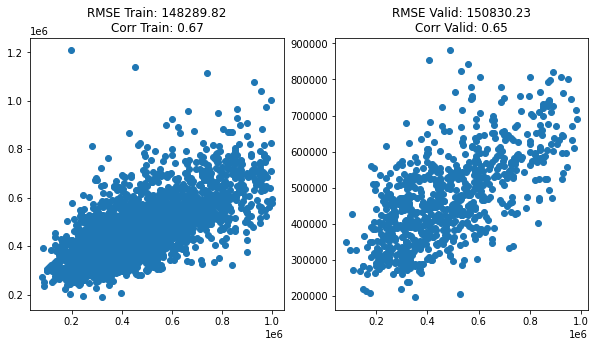

In [312]:
# Train model with elastic net
train_model(ElasticNet(l1_ratio=0.9), X_train, y_train, X_val, y_val)

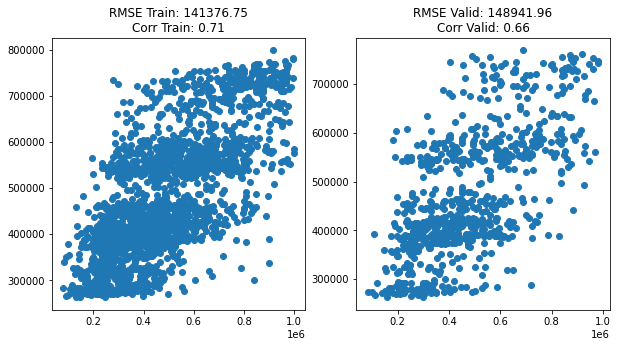

In [305]:
# Train model with Random Forest
train_model(RandomForestRegressor(max_depth=4), X_train, y_train, X_val, y_val)

In [313]:
''' Next Steps:
- Review removed cases in more detail
- Review variable interactions in more detail e.g. impact of categorical and continuous variable interactions
- Review and OHE categorical variables.
- Create ML pipeline with transformations and prediction
- Specify random seed for reproducible model iterations.
- Add polynomial features e.g. for bedrooms, average prices increase but gradually stabilize
- Apply HP search for model tuning.
- Test model performance on test set.
'''

' Next Steps:\n- Review removed cases in more detail\n- Review variable interactions in more detail e.g. impact of categorical and continuous variable interactions\n- Review and OHE categorical variables.\n- Create ML pipeline with transformations and prediction\n- Specify random seed for reproducible model iterations.\n- Add polynomial features e.g. for bedrooms, average prices increase but gradually stabilize\n- Apply HP search for model tuning.\n- Test model performance on test set.\n'